<a href="https://colab.research.google.com/github/ashinkrishnan/Sentiment-Analysis-using-Attention-Model/blob/main/attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH ="/content/drive/MyDrive/twitter-sentiment/train (1).csv"

In [6]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



df = pd.read_csv(PATH)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
df.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [9]:
#data cleaning function
def clean_text(text):
    text = re.sub(r'[^w\w\s]','',text,re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if  not word in stop_words]
    text = " ".join(text)
    return text

In [10]:
df['Processed_tweet'] = df.tweet.apply(lambda x: clean_text(x))

In [11]:
df['tweet'][0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [12]:
df['Processed_tweet'][0]

' user father dysfunctional selfish drag kid dysfunction   run'

In [13]:
#getting the max length of the sequnce to apply padding
df.Processed_tweet.apply(lambda x: len(x.split(" "))).max()

39

In [14]:
MAX_FEATURES = 8000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Processed_tweet'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_tweet'])

In [15]:
MAX_LEN = 40 #since the max length of the input 
X_train = pad_sequences(list_tokenized_train,maxlen =MAX_LEN )
y = df['label']
y_train = np.asarray(y)

In [16]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [18]:
#CREATING ATTENTION LAYER

In [19]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V  = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [20]:
#Embedding Layer using random initialization
#To perform this embedding we use the Embedding function from the layers package

In [21]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [22]:
# Bi-directional RNN for Encoding section
RNN_CELL_SIZE = 32
lstm = Bidirectional(LSTM(RNN_CELL_SIZE,return_sequences= True),name="bi-dir-lstm0")(embedded_sequences)
#Gettig LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi-dir-lstm1")(lstm)

In [23]:
#Since our model uses a bi-directional RNN, 
#we first concatenate the hidden states from each RNN before computing the attention weights and applying the weighted sum

In [24]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

In [25]:
model = keras.Model(inputs=sequence_input, outputs=output)

In [26]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
bi-dir-lstm0 (Bidirectional)    (None, 40, 64)       41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi-dir-lstm1 (Bidirectional)    [(None, 40, 64), (No 24832       bi-dir-lstm0[0][0]               
______________________________________________________________________________________________

In [27]:
#graph of the connected layers using  pydot/graphviz

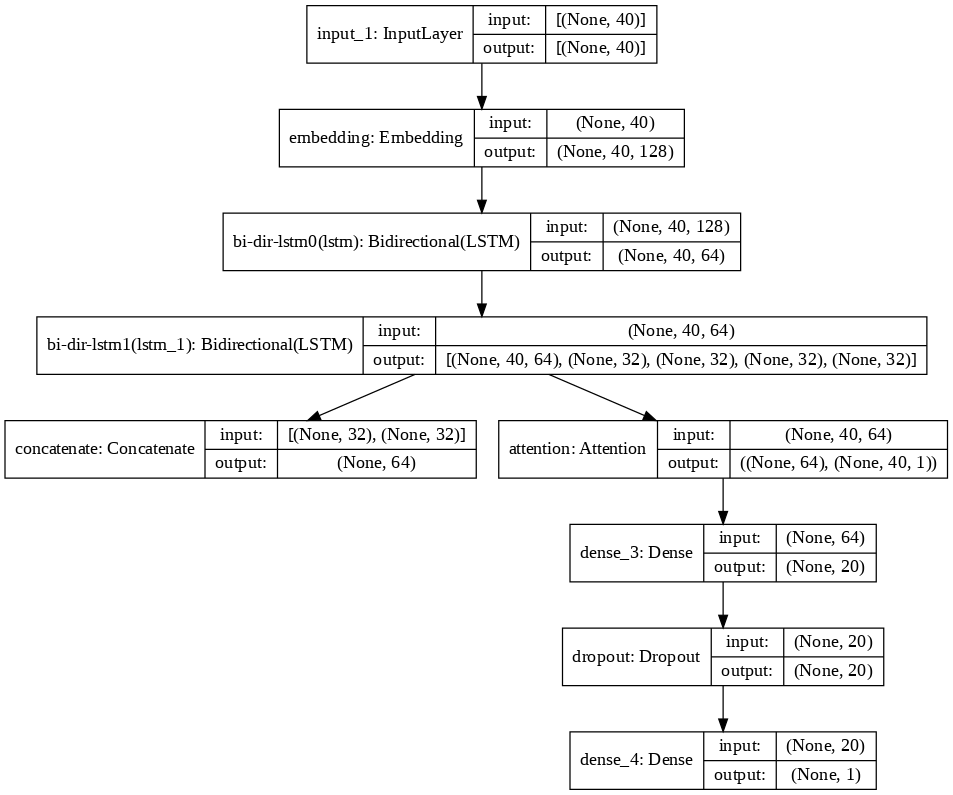

In [28]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [29]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [30]:
#Training the model
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
256/256 [==============================] - 22s 37ms/step - loss: 0.1929 - tp: 515.0000 - fp: 150.0000 - tn: 23621.0000 - fn: 1283.0000 - accuracy: 0.9440 - precision: 0.7744 - recall: 0.2864 - auc: 0.8402 - val_loss: 0.1238 - val_tp: 270.0000 - val_fp: 94.0000 - val_tn: 5855.0000 - val_fn: 174.0000 - val_accuracy: 0.9581 - val_precision: 0.7418 - val_recall: 0.6081 - val_auc: 0.9524
Epoch 2/5
256/256 [==============================] - 7s 29ms/step - loss: 0.0856 - tp: 1275.0000 - fp: 222.0000 - tn: 23549.0000 - fn: 523.0000 - accuracy: 0.9709 - precision: 0.8517 - recall: 0.7091 - auc: 0.9695 - val_loss: 0.1235 - val_tp: 226.0000 - val_fp: 31.0000 - val_tn: 5918.0000 - val_fn: 218.0000 - val_accuracy: 0.9611 - val_precision: 0.8794 - val_recall: 0.5090 - val_auc: 0.9468
Epoch 3/5
256/256 [==============================] - 7s 29ms/step - loss: 0.0585 - tp: 1443.0000 - fp: 151.0000 - tn: 23620.0000 - fn: 355.0000 - accuracy: 0.9802 - precision: 0.9053 - recall: 0.8026 - auc: 0.

In [31]:
#evaluating the model using test data

In [32]:
#Loading the test data,and repeating the precessing step
df_test = pd.read_csv("/content/drive/MyDrive/twitter-sentiment/train.csv")
df_test.head()
df_test['tweet'] = df_test.tweet.apply(lambda x: clean_text(x))
y_t = df_test['label']

y_test = np.asarray(y_t)

list_sentences_test = df_test["tweet"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

## Making predictions on our model
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)




              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29720
           1       0.94      0.88      0.91      2242

    accuracy                           0.99     31962
   macro avg       0.96      0.94      0.95     31962
weighted avg       0.99      0.99      0.99     31962



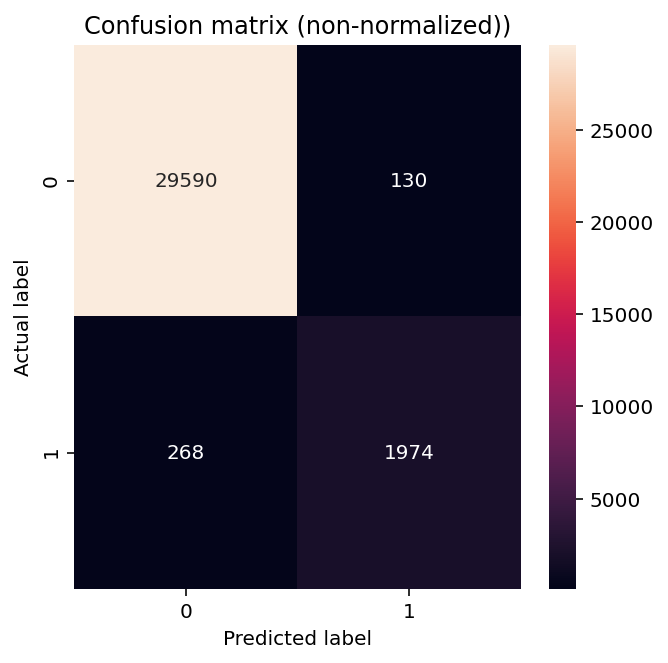

In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, y_pred)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(y_test, y_pred)

In [35]:
# # Cross Validation Classification Accuracy
  
# colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# mpl.rcParams["figure.figsize"] = (12, 18)
  
# def plot_metrics(history):
#     metrics = [
#         "loss",
#         "tp", "fp", "tn", "fn",
#         "accuracy",
#         "precision", "recall",
#         "auc",
#     ]
#     for n, metric in  enumerate(metrics):
#         name = metric.replace("_", " ").capitalize()
#         plt.subplot(5, 2, n + 1)
#         plt.plot(
#             history.epoch,
#             history.history[metric],
#             color=colors[0],
#             label="Train",
#         )
#         plt.plot(
#             history.epoch,
#             history.history["val_" + metric],
#             color=colors[1],
#             linestyle="--",
#             label="Val",
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel(name)
#         if metric == "loss":
#             plt.ylim([0, plt.ylim()[1] * 1.2])
#         elif metric == "accuracy":
#             plt.ylim([0.4, 1])
#         elif metric == "fn":
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == "fp":
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == "tn":
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == "tp":
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == "precision":
#             plt.ylim([0, 1])
#         elif metric == "recall":
#             plt.ylim([0.4, 1])
#         else:
#             plt.ylim([0, 1])
          
#         plt.legend()
  
# plot_metrics(history)